In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
file_path = './filtered_feature_bc_matrix'
results_file = './pbmc3k_processed.h5ad'
adata = sc.read_10x_mtx(file_path, cache=True)

... reading from cache file cache\filtered_feature_bc_matrix-matrix.h5ad


In [24]:
adata

AnnData object with n_obs × n_vars = 5527 × 33538 
    var: 'gene_ids', 'feature_types'

In [25]:
#filter cells based on genes, counts and percent_mito
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_cells(adata, min_counts=0)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

... storing 'feature_types' as categorical


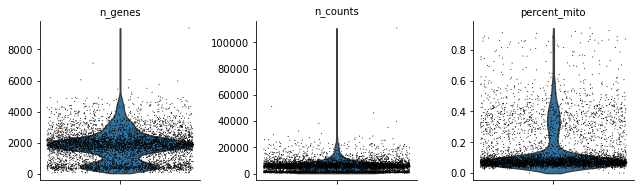

In [26]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

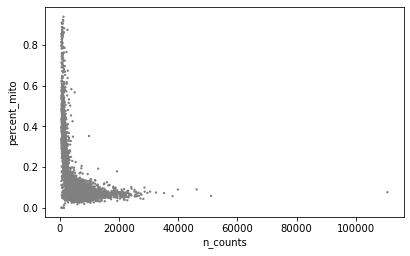

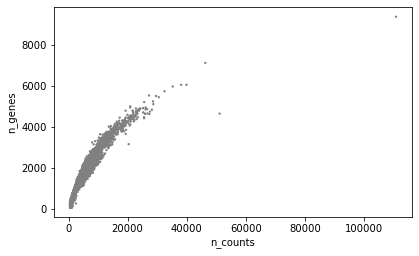

In [27]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [28]:
#use following conditions
sc.pp.filter_cells(adata, min_genes=1200)
sc.pp.filter_cells(adata, max_genes=3000)
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=30000)
adata = adata[adata.obs.percent_mito < 0.6, :]

filtered out 1428 cells that have less than 1200 genes expressed
filtered out 554 cells that have more than 3000 genes expressed
filtered out 236 cells that have less than 4000 counts


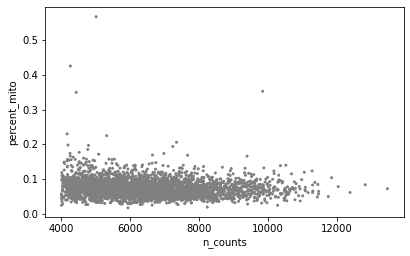

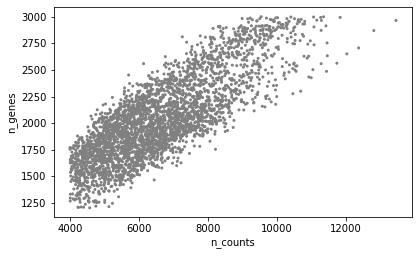

In [29]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [30]:
adata

View of AnnData object with n_obs × n_vars = 3309 × 33538 
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types'

In [31]:
sc.pp.filter_genes(adata, min_cells=0)

Trying to set attribute `.var` of view, copying.


In [32]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16449 genes that are detected in less than 3 cells


In [33]:
adata

AnnData object with n_obs × n_vars = 3309 × 17089 
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [34]:
#normalization
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [35]:
sc.pp.log1p(adata)

In [36]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


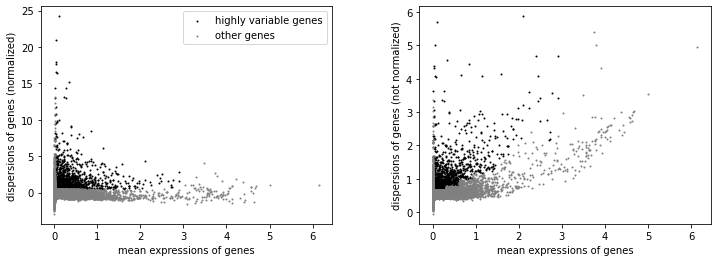

In [37]:
sc.pl.highly_variable_genes(adata)

In [38]:
adata = adata[:, adata.var.highly_variable]

In [39]:
adata

View of AnnData object with n_obs × n_vars = 3309 × 1764 
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [40]:
#preprocessing over

In [41]:
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


In [42]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=None)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


In [43]:
 sc.tl.louvain(adata, resolution=1.0, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [44]:
sc.tl.umap(adata, random_state=0, n_components=3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


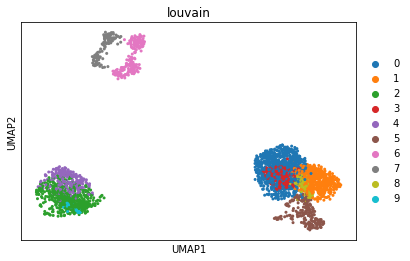

In [45]:
sc.pl.umap(adata, color=['louvain'])

In [46]:
#dimensional reduction over

In [47]:
# a useful function for transposition<list(map(list, zip(*coordinate)))>

In [48]:
sc.tl.rank_genes_groups(adata,'louvain', method="t-test")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


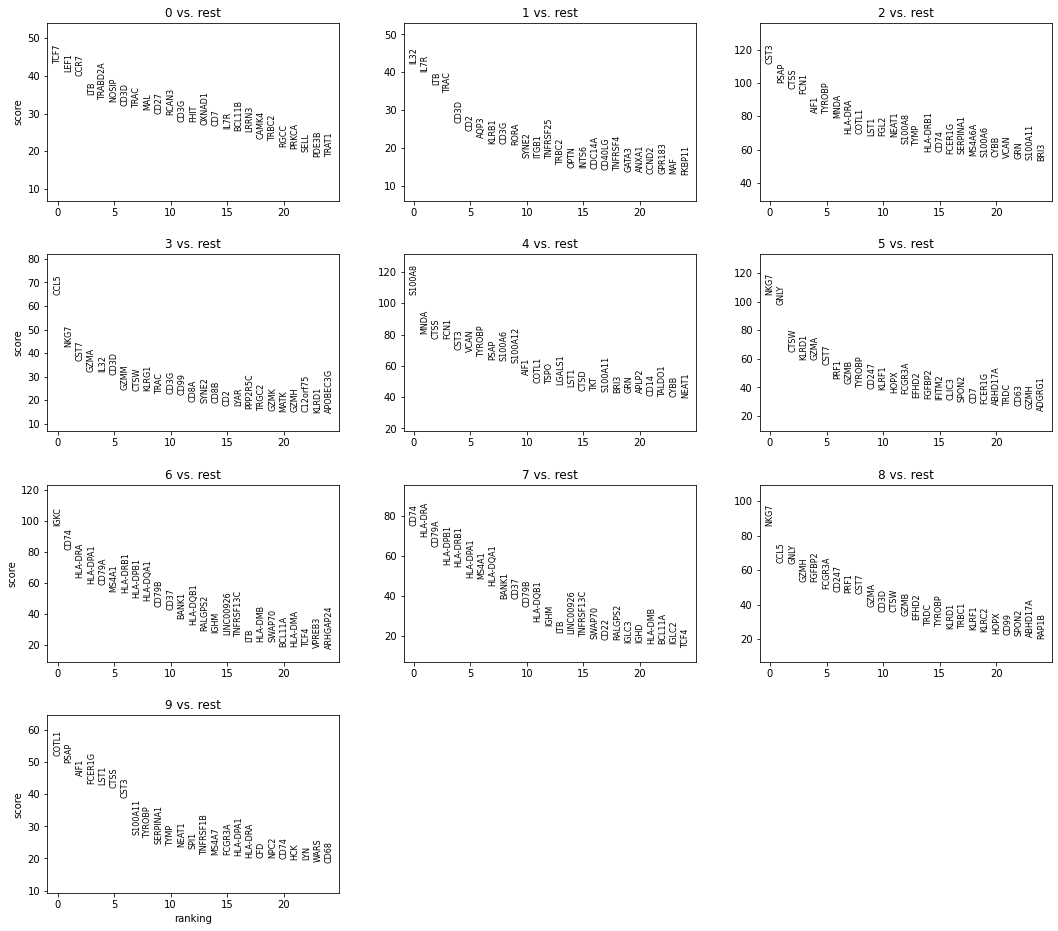

In [49]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=3)

In [50]:
adata

AnnData object with n_obs × n_vars = 3309 × 1764 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [51]:
adata.write(results_file)

In [52]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9
0,TCF7,IL32,CST3,CCL5,S100A8,NKG7,IGKC,CD74,NKG7,COTL1
1,LEF1,IL7R,PSAP,NKG7,MNDA,GNLY,CD74,HLA-DRA,CCL5,PSAP
2,CCR7,LTB,CTSS,CST7,CTSS,CTSW,HLA-DRA,CD79A,GNLY,AIF1
3,LTB,TRAC,FCN1,GZMA,FCN1,KLRD1,HLA-DPA1,HLA-DPB1,GZMH,FCER1G
4,TRABD2A,CD3D,AIF1,IL32,CST3,GZMA,CD79A,HLA-DRB1,FGFBP2,LST1


In [53]:
bdata = sc.read_h5ad('./pbmc3k_processed.h5ad')

In [54]:
bdata

AnnData object with n_obs × n_vars = 3309 × 1764 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [55]:
bdata.X

<3309x1764 sparse matrix of type '<class 'numpy.float32'>'
	with 807213 stored elements in Compressed Sparse Row format>

In [56]:
type(bdata.X)

scipy.sparse.csr.csr_matrix

In [57]:
bdata

AnnData object with n_obs × n_vars = 3309 × 1764 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [58]:
bdata.var.keys()

Index(['gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm'],
      dtype='object')

In [59]:
bdata.var.gene_ids

HES4          ENSG00000188290
ISG15         ENSG00000187608
TNFRSF18      ENSG00000186891
TNFRSF4       ENSG00000186827
AL645728.1    ENSG00000215014
                   ...       
MX1           ENSG00000157601
PDXK          ENSG00000160209
AP001059.2    ENSG00000275799
COL6A2        ENSG00000142173
S100B         ENSG00000160307
Name: gene_ids, Length: 1764, dtype: object

In [68]:
bdata.var['gene_ids'].index

Index(['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'AL645728.1', 'MMP23B', 'NADK',
       'PLCH2', 'AL139246.3', 'TNFRSF25',
       ...
       'KCNE1', 'DOPEY2', 'ETS2', 'BACE2', 'MX2', 'MX1', 'PDXK', 'AP001059.2',
       'COL6A2', 'S100B'],
      dtype='object', length=1764)

In [32]:
adata = sc.read_10x_h5('./pbmc_1k_v3_filtered_feature_bc_matrix.h5')

reading ./pbmc_1k_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [36]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [6]:
adata.X

<4000x28000 sparse matrix of type '<class 'numpy.float32'>'
	with 11566 stored elements in Compressed Sparse Row format>

In [21]:
with h5py.File('./pbmc_1k_v3_filtered_feature_bc_matrix.h5', "r") as f:
        # the following is necessary in Python 3, because only
        # a view and not a list is returned
        keys = [k for k in f.keys()]
        X = f['matrix'][()]

AttributeError: 'tuple' object has no attribute 'encode'

In [11]:
import h5py

In [14]:
keys

['matrix']

In [15]:
f

<Closed HDF5 file>

In [18]:
f['matrix'][()]

ValueError: Not a location (invalid object ID)

In [27]:
with h5py.File('./pbmc_1k_v3_filtered_feature_bc_matrix.h5', "r") as f:
        # the following is necessary in Python 3, because only
        # a view and not a list is returned
        keys = [k for k in f.keys()]
        print(keys)
        if key == "":
            raise ValueError(
                f"The file {filename} stores the following sheets:\n{keys}\n"
                f"Call read/read_hdf5 with one of them."
            )
        # read array
        X = f[key][()]
        # try to find row and column names
        rows_cols = [{}, {}]
        for iname, name in enumerate(["row_names", "col_names"]):
            if name in keys:
                rows_cols[iname][name] = f[name][()]
        adata = AnnData(X, rows_cols[0], rows_cols[1], dtype=X.dtype.name)

['matrix']


NameError: name 'key' is not defined

In [4]:
adata=sc.read_h5ad('./pbmc3k_processed.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 3309 × 1764 
    obs: 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [6]:
adata.obs.louvain

AAACCCACAGGCTTGC-1    2
AAACCCAGTAGTTAGA-1    2
AAACGAAGTGGATCAG-1    2
AAACGAATCATGAGAA-1    0
AAACGAATCGTCCTTG-1    2
                     ..
TTTGATCGTTACGCCG-1    0
TTTGGAGAGGTAGCCA-1    0
TTTGGAGGTATCGATC-1    1
TTTGGTTCAATTTCCT-1    2
TTTGGTTGTTGGAGAC-1    0
Name: louvain, Length: 3309, dtype: category
Categories (10, object): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [7]:
usb = adata.obs.louvain.values

In [9]:
usb = usb.tolist()

In [24]:
usb

['2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '7',
 '0',
 '5',
 '7',
 '0',
 '0',
 '1',
 '1',
 '0',
 '2',
 '9',
 '4',
 '0',
 '9',
 '0',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '4',
 '1',
 '3',
 '0',
 '5',
 '5',
 '5',
 '3',
 '7',
 '1',
 '1',
 '2',
 '0',
 '4',
 '2',
 '2',
 '1',
 '4',
 '3',
 '3',
 '3',
 '5',
 '1',
 '4',
 '0',
 '6',
 '0',
 '4',
 '0',
 '0',
 '6',
 '0',
 '1',
 '1',
 '0',
 '6',
 '0',
 '5',
 '2',
 '2',
 '0',
 '4',
 '1',
 '6',
 '4',
 '4',
 '2',
 '0',
 '2',
 '3',
 '0',
 '2',
 '3',
 '7',
 '1',
 '5',
 '0',
 '0',
 '8',
 '4',
 '1',
 '5',
 '0',
 '0',
 '3',
 '1',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '0',
 '9',
 '3',
 '0',
 '1',
 '0',
 '1',
 '5',
 '1',
 '2',
 '0',
 '1',
 '5',
 '0',
 '0',
 '8',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '6',
 '8',
 '1',
 '1',
 '3',
 '9',
 '6',
 '5',
 '1',
 '4',
 '0',
 '4',
 '1',
 '2',
 '3',
 '1',
 '5',
 '0',
 '0',
 '9',
 '1',
 '1',
 '4',
 '5',
 '1',
 '0',
 '2'

In [20]:
adata.obs['usb'] = pd.Series(usb)

In [21]:
adata.obs.usb

array(['2', '2', '2', ..., '1', '2', '0'], dtype=object)

In [23]:
type(adata.obs.n_counts)

pandas.core.series.Series

In [19]:
type(adata.obs.usb)

numpy.ndarray

In [27]:
adata.obs.assign(usc=usb)

,n_genes,n_counts,percent_mito,louvain,usb
AAACCCACAGGCTTGC-1,1685,4428.0,0.119241,2,2
AAACCCAGTAGTTAGA-1,2291,7107.0,0.059519,2,2
AAACGAAGTGGATCAG-1,1850,4838.0,0.076685,2,2
AAACGAATCATGAGAA-1,1410,4244.0,0.047361,0,0
AAACGAATCGTCCTTG-1,1593,4055.0,0.101850,2,2
...,...,...,...,...,...
TTTGATCGTTACGCCG-1,1591,6504.0,0.089637,0,0
TTTGGAGAGGTAGCCA-1,1957,6569.0,0.051302,0,0
TTTGGAGGTATCGATC-1,1411,4803.0,0.083281,1,1
TTTGGTTCAATTTCCT-1,2850,8431.0,0.083146,2,2


In [28]:
adata.obs.usb

array(['2', '2', '2', ..., '1', '2', '0'], dtype=object)

In [29]:
usb

['2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '7',
 '0',
 '5',
 '7',
 '0',
 '0',
 '1',
 '1',
 '0',
 '2',
 '9',
 '4',
 '0',
 '9',
 '0',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '4',
 '1',
 '3',
 '0',
 '5',
 '5',
 '5',
 '3',
 '7',
 '1',
 '1',
 '2',
 '0',
 '4',
 '2',
 '2',
 '1',
 '4',
 '3',
 '3',
 '3',
 '5',
 '1',
 '4',
 '0',
 '6',
 '0',
 '4',
 '0',
 '0',
 '6',
 '0',
 '1',
 '1',
 '0',
 '6',
 '0',
 '5',
 '2',
 '2',
 '0',
 '4',
 '1',
 '6',
 '4',
 '4',
 '2',
 '0',
 '2',
 '3',
 '0',
 '2',
 '3',
 '7',
 '1',
 '5',
 '0',
 '0',
 '8',
 '4',
 '1',
 '5',
 '0',
 '0',
 '3',
 '1',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '0',
 '9',
 '3',
 '0',
 '1',
 '0',
 '1',
 '5',
 '1',
 '2',
 '0',
 '1',
 '5',
 '0',
 '0',
 '8',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '6',
 '8',
 '1',
 '1',
 '3',
 '9',
 '6',
 '5',
 '1',
 '4',
 '0',
 '4',
 '1',
 '2',
 '3',
 '1',
 '5',
 '0',
 '0',
 '9',
 '1',
 '1',
 '4',
 '5',
 '1',
 '0',
 '2'

In [30]:
ns = usb.copy()

In [31]:
ns

['2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '7',
 '0',
 '5',
 '7',
 '0',
 '0',
 '1',
 '1',
 '0',
 '2',
 '9',
 '4',
 '0',
 '9',
 '0',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '4',
 '1',
 '3',
 '0',
 '5',
 '5',
 '5',
 '3',
 '7',
 '1',
 '1',
 '2',
 '0',
 '4',
 '2',
 '2',
 '1',
 '4',
 '3',
 '3',
 '3',
 '5',
 '1',
 '4',
 '0',
 '6',
 '0',
 '4',
 '0',
 '0',
 '6',
 '0',
 '1',
 '1',
 '0',
 '6',
 '0',
 '5',
 '2',
 '2',
 '0',
 '4',
 '1',
 '6',
 '4',
 '4',
 '2',
 '0',
 '2',
 '3',
 '0',
 '2',
 '3',
 '7',
 '1',
 '5',
 '0',
 '0',
 '8',
 '4',
 '1',
 '5',
 '0',
 '0',
 '3',
 '1',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '0',
 '9',
 '3',
 '0',
 '1',
 '0',
 '1',
 '5',
 '1',
 '2',
 '0',
 '1',
 '5',
 '0',
 '0',
 '8',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '6',
 '8',
 '1',
 '1',
 '3',
 '9',
 '6',
 '5',
 '1',
 '4',
 '0',
 '4',
 '1',
 '2',
 '3',
 '1',
 '5',
 '0',
 '0',
 '9',
 '1',
 '1',
 '4',
 '5',
 '1',
 '0',
 '2'

In [35]:
adata.obs = adata.obs.assign(fuc=ns)

In [36]:
adata.obs

,n_genes,n_counts,percent_mito,louvain,usb,fuc
AAACCCACAGGCTTGC-1,1685,4428.0,0.119241,2,NaN,2
AAACCCAGTAGTTAGA-1,2291,7107.0,0.059519,2,NaN,2
AAACGAAGTGGATCAG-1,1850,4838.0,0.076685,2,NaN,2
AAACGAATCATGAGAA-1,1410,4244.0,0.047361,0,NaN,0
AAACGAATCGTCCTTG-1,1593,4055.0,0.101850,2,NaN,2
...,...,...,...,...,...,...
TTTGATCGTTACGCCG-1,1591,6504.0,0.089637,0,NaN,0
TTTGGAGAGGTAGCCA-1,1957,6569.0,0.051302,0,NaN,0
TTTGGAGGTATCGATC-1,1411,4803.0,0.083281,1,NaN,1
TTTGGTTCAATTTCCT-1,2850,8431.0,0.083146,2,NaN,2


In [37]:
adata.obs.fuc

AAACCCACAGGCTTGC-1    2
AAACCCAGTAGTTAGA-1    2
AAACGAAGTGGATCAG-1    2
AAACGAATCATGAGAA-1    0
AAACGAATCGTCCTTG-1    2
                     ..
TTTGATCGTTACGCCG-1    0
TTTGGAGAGGTAGCCA-1    0
TTTGGAGGTATCGATC-1    1
TTTGGTTCAATTTCCT-1    2
TTTGGTTGTTGGAGAC-1    0
Name: fuc, Length: 3309, dtype: object

In [38]:
ns

['2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '7',
 '0',
 '5',
 '7',
 '0',
 '0',
 '1',
 '1',
 '0',
 '2',
 '9',
 '4',
 '0',
 '9',
 '0',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '4',
 '1',
 '3',
 '0',
 '5',
 '5',
 '5',
 '3',
 '7',
 '1',
 '1',
 '2',
 '0',
 '4',
 '2',
 '2',
 '1',
 '4',
 '3',
 '3',
 '3',
 '5',
 '1',
 '4',
 '0',
 '6',
 '0',
 '4',
 '0',
 '0',
 '6',
 '0',
 '1',
 '1',
 '0',
 '6',
 '0',
 '5',
 '2',
 '2',
 '0',
 '4',
 '1',
 '6',
 '4',
 '4',
 '2',
 '0',
 '2',
 '3',
 '0',
 '2',
 '3',
 '7',
 '1',
 '5',
 '0',
 '0',
 '8',
 '4',
 '1',
 '5',
 '0',
 '0',
 '3',
 '1',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '0',
 '9',
 '3',
 '0',
 '1',
 '0',
 '1',
 '5',
 '1',
 '2',
 '0',
 '1',
 '5',
 '0',
 '0',
 '8',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '6',
 '8',
 '1',
 '1',
 '3',
 '9',
 '6',
 '5',
 '1',
 '4',
 '0',
 '4',
 '1',
 '2',
 '3',
 '1',
 '5',
 '0',
 '0',
 '9',
 '1',
 '1',
 '4',
 '5',
 '1',
 '0',
 '2'

In [39]:
us = ns.copy()

In [40]:
adata.obs = adata.obs.assign(fw=us)

In [41]:
adata.obs

,n_genes,n_counts,percent_mito,louvain,usb,fuc,fw
AAACCCACAGGCTTGC-1,1685,4428.0,0.119241,2,NaN,2,2
AAACCCAGTAGTTAGA-1,2291,7107.0,0.059519,2,NaN,2,2
AAACGAAGTGGATCAG-1,1850,4838.0,0.076685,2,NaN,2,2
AAACGAATCATGAGAA-1,1410,4244.0,0.047361,0,NaN,0,0
AAACGAATCGTCCTTG-1,1593,4055.0,0.101850,2,NaN,2,2
...,...,...,...,...,...,...,...
TTTGATCGTTACGCCG-1,1591,6504.0,0.089637,0,NaN,0,0
TTTGGAGAGGTAGCCA-1,1957,6569.0,0.051302,0,NaN,0,0
TTTGGAGGTATCGATC-1,1411,4803.0,0.083281,1,NaN,1,1
TTTGGTTCAATTTCCT-1,2850,8431.0,0.083146,2,NaN,2,2


In [44]:
type(adata.obs.fw)

pandas.core.series.Series

In [45]:
adata.obs.fw = adata.obs.fw.astype('category')

In [50]:
adata.obs.fw

AAACCCACAGGCTTGC-1    2
AAACCCAGTAGTTAGA-1    2
AAACGAAGTGGATCAG-1    2
AAACGAATCATGAGAA-1    0
AAACGAATCGTCCTTG-1    2
                     ..
TTTGATCGTTACGCCG-1    0
TTTGGAGAGGTAGCCA-1    0
TTTGGAGGTATCGATC-1    1
TTTGGTTCAATTTCCT-1    2
TTTGGTTGTTGGAGAC-1    0
Name: fw, Length: 3309, dtype: category
Categories (10, object): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [51]:
type(adata.obs.fw)

pandas.core.series.Series

In [53]:
adata.obs.fw.cat.categories.values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [77]:
for index, value in adata.obs.fuc.items():
    print(f"Index : {index}, Value: {value}")

Index : AAACCCACAGGCTTGC-1, Value: 2
Index : AAACCCAGTAGTTAGA-1, Value: 2
Index : AAACGAAGTGGATCAG-1, Value: 2
Index : AAACGAATCATGAGAA-1, Value: 0
Index : AAACGAATCGTCCTTG-1, Value: 2
Index : AAACGCTAGGATAATC-1, Value: 0
Index : AAACGCTTCTGTCGTC-1, Value: 5
Index : AAAGAACAGGAGGTTC-1, Value: 2
Index : AAAGGATAGCCGGATA-1, Value: 0
Index : AAAGGATTCCGAGTGC-1, Value: 1
Index : AAAGGGCCACTTCTCG-1, Value: 2
Index : AAAGGGCCATTGTGCA-1, Value: 0
Index : AAAGGTAAGCGACATG-1, Value: 0
Index : AAAGGTAAGGTGCTTT-1, Value: 0
Index : AAAGGTAGTAAGTTAG-1, Value: 0
Index : AAAGGTATCATTTACC-1, Value: 0
Index : AAAGGTATCTGTCCCA-1, Value: 2
Index : AAAGTCCAGTTAGTGA-1, Value: 0
Index : AAAGTCCTCCACAGGC-1, Value: 0
Index : AAAGTGAAGAAAGCGA-1, Value: 7
Index : AAAGTGACATGCGGTC-1, Value: 2
Index : AAAGTGAGTACGAAAT-1, Value: 1
Index : AAAGTGATCCTCTTTC-1, Value: 2
Index : AACAAAGAGAGTGTGC-1, Value: 7
Index : AACAAAGAGGTAACTA-1, Value: 0
Index : AACAAAGAGTAATCCC-1, Value: 5
Index : AACAAAGAGTCTGGAG-1, Value: 7
I

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [85]:
int(adata.obs.fuc.max())+1

10

In [92]:
adata.obs.pop('usb')

AAACCCACAGGCTTGC-1    NaN
AAACCCAGTAGTTAGA-1    NaN
AAACGAAGTGGATCAG-1    NaN
AAACGAATCATGAGAA-1    NaN
AAACGAATCGTCCTTG-1    NaN
                     ... 
TTTGATCGTTACGCCG-1    NaN
TTTGGAGAGGTAGCCA-1    NaN
TTTGGAGGTATCGATC-1    NaN
TTTGGTTCAATTTCCT-1    NaN
TTTGGTTGTTGGAGAC-1    NaN
Name: usb, Length: 3309, dtype: object

In [94]:
ns

['2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '5',
 '2',
 '0',
 '1',
 '2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '0',
 '7',
 '2',
 '1',
 '2',
 '7',
 '0',
 '5',
 '7',
 '0',
 '0',
 '1',
 '1',
 '0',
 '2',
 '9',
 '4',
 '0',
 '9',
 '0',
 '2',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '4',
 '1',
 '3',
 '0',
 '5',
 '5',
 '5',
 '3',
 '7',
 '1',
 '1',
 '2',
 '0',
 '4',
 '2',
 '2',
 '1',
 '4',
 '3',
 '3',
 '3',
 '5',
 '1',
 '4',
 '0',
 '6',
 '0',
 '4',
 '0',
 '0',
 '6',
 '0',
 '1',
 '1',
 '0',
 '6',
 '0',
 '5',
 '2',
 '2',
 '0',
 '4',
 '1',
 '6',
 '4',
 '4',
 '2',
 '0',
 '2',
 '3',
 '0',
 '2',
 '3',
 '7',
 '1',
 '5',
 '0',
 '0',
 '8',
 '4',
 '1',
 '5',
 '0',
 '0',
 '3',
 '1',
 '3',
 '0',
 '0',
 '0',
 '1',
 '2',
 '0',
 '0',
 '9',
 '3',
 '0',
 '1',
 '0',
 '1',
 '5',
 '1',
 '2',
 '0',
 '1',
 '5',
 '0',
 '0',
 '8',
 '2',
 '2',
 '4',
 '0',
 '4',
 '4',
 '6',
 '8',
 '1',
 '1',
 '3',
 '9',
 '6',
 '5',
 '1',
 '4',
 '0',
 '4',
 '1',
 '2',
 '3',
 '1',
 '5',
 '0',
 '0',
 '9',
 '1',
 '1',
 '4',
 '5',
 '1',
 '0',
 '2'

In [95]:
adata.obs = adata.obs.assign()

In [97]:
text = 'fuck'
adata.obs = adata.obs.assign(text=ns)

In [99]:
adata.obs

,n_genes,n_counts,percent_mito,louvain,fuc,fw,text
AAACCCACAGGCTTGC-1,1685,4428.0,0.119241,2,2,2,2
AAACCCAGTAGTTAGA-1,2291,7107.0,0.059519,2,2,2,2
AAACGAAGTGGATCAG-1,1850,4838.0,0.076685,2,2,2,2
AAACGAATCATGAGAA-1,1410,4244.0,0.047361,0,0,0,0
AAACGAATCGTCCTTG-1,1593,4055.0,0.101850,2,2,2,2
...,...,...,...,...,...,...,...
TTTGATCGTTACGCCG-1,1591,6504.0,0.089637,0,0,0,0
TTTGGAGAGGTAGCCA-1,1957,6569.0,0.051302,0,0,0,0
TTTGGAGGTATCGATC-1,1411,4803.0,0.083281,1,1,1,1
TTTGGTTCAATTTCCT-1,2850,8431.0,0.083146,2,2,2,2
